<a href="https://www.kaggle.com/ranjeetshrivastav/tps-may-2021-stacking?scriptVersionId=88455485" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from cycler import cycler
import matplotlib as mpl

raw_light_palette = [
    (0, 122, 255), # Blue
    (255, 149, 0), # Orange
    (52, 199, 89), # Green
    (255, 59, 48), # Red
    (175, 82, 222),# Purple
    (255, 45, 85), # Pink
    (88, 86, 214), # Indigo
    (90, 200, 250),# Teal
    (255, 204, 0)  # Yellow
]

raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
]

raw_gray_light_palette = [
    (142, 142, 147),# Gray
    (174, 174, 178),# Gray (2)
    (199, 199, 204),# Gray (3)
    (209, 209, 214),# Gray (4)
    (229, 229, 234),# Gray (5)
    (242, 242, 247),# Gray (6)
]

raw_gray_dark_palette = [
    (142, 142, 147),# Gray
    (99, 99, 102),  # Gray (2)
    (72, 72, 74),   # Gray (3)
    (58, 58, 60),   # Gray (4)
    (44, 44, 46),   # Gray (5)
    (28, 28, 39),   # Gray (6)
]

light_palette = np.array(raw_light_palette)/255
dark_palette = np.array(raw_dark_palette)/255
gray_light_palette = np.array(raw_gray_light_palette)/255
gray_dark_palette = np.array(raw_gray_dark_palette)/255

mpl.rcParams['axes.prop_cycle'] = cycler('color',dark_palette)
mpl.rcParams['figure.facecolor']  = gray_dark_palette[-2]
mpl.rcParams['figure.edgecolor']  = gray_dark_palette[-2]
mpl.rcParams['axes.facecolor'] =  gray_dark_palette[-2]

white_color = gray_light_palette[-2]
mpl.rcParams['text.color'] = white_color
mpl.rcParams['axes.labelcolor'] = white_color
mpl.rcParams['axes.edgecolor'] = white_color
mpl.rcParams['xtick.color'] = white_color
mpl.rcParams['ytick.color'] = white_color

mpl.rcParams['figure.dpi'] = 200

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False


In [3]:
# Import the data
train = pd.read_csv("../input/tabular-playground-series-may-2021/train.csv")
test = pd.read_csv("../input/tabular-playground-series-may-2021/test.csv")
sample_submission = pd.read_csv("../input/tabular-playground-series-may-2021/sample_submission.csv")

In [4]:
train.shape, test.shape

((100000, 52), (50000, 51))

The id value is meaningless, so I will leave it out in advance.

In [5]:
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

### Data Visualization

* Data visualization reference: [https://www.kaggle.com/subinium/tps-may-categorical-eda](https://www.kaggle.com/subinium/tps-may-categorical-eda)

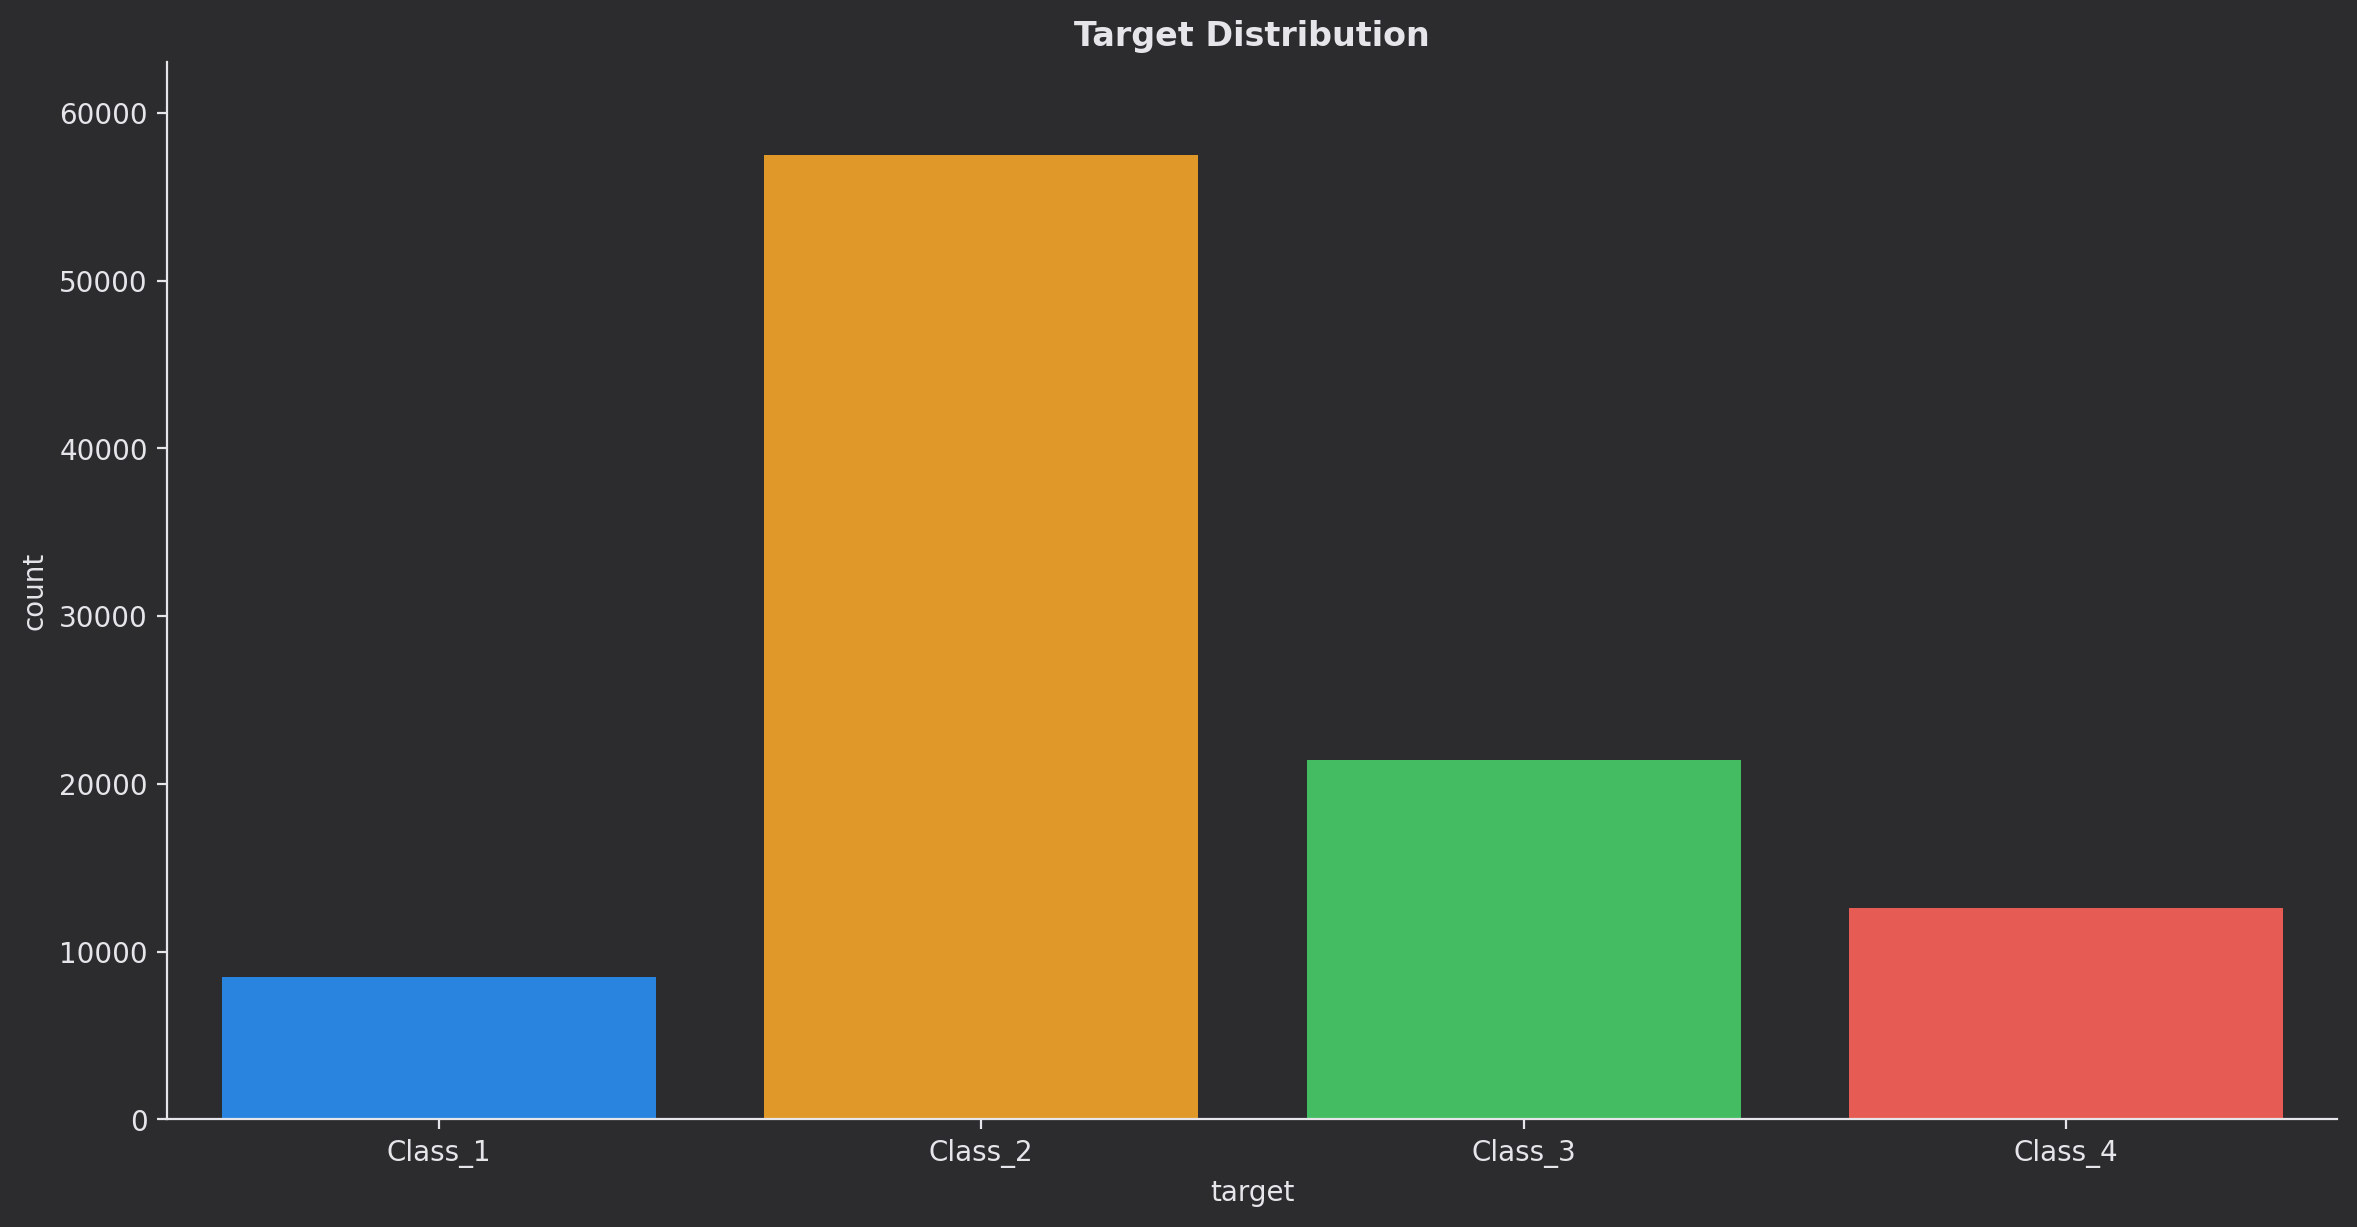

In [6]:
plt.figure(figsize=(14,7))
sns.countplot(x='target', data=train, order=sorted(train['target'].unique()))
plt.ylim(0, 63000)
plt.title('Target Distribution', weight='bold')
plt.show()

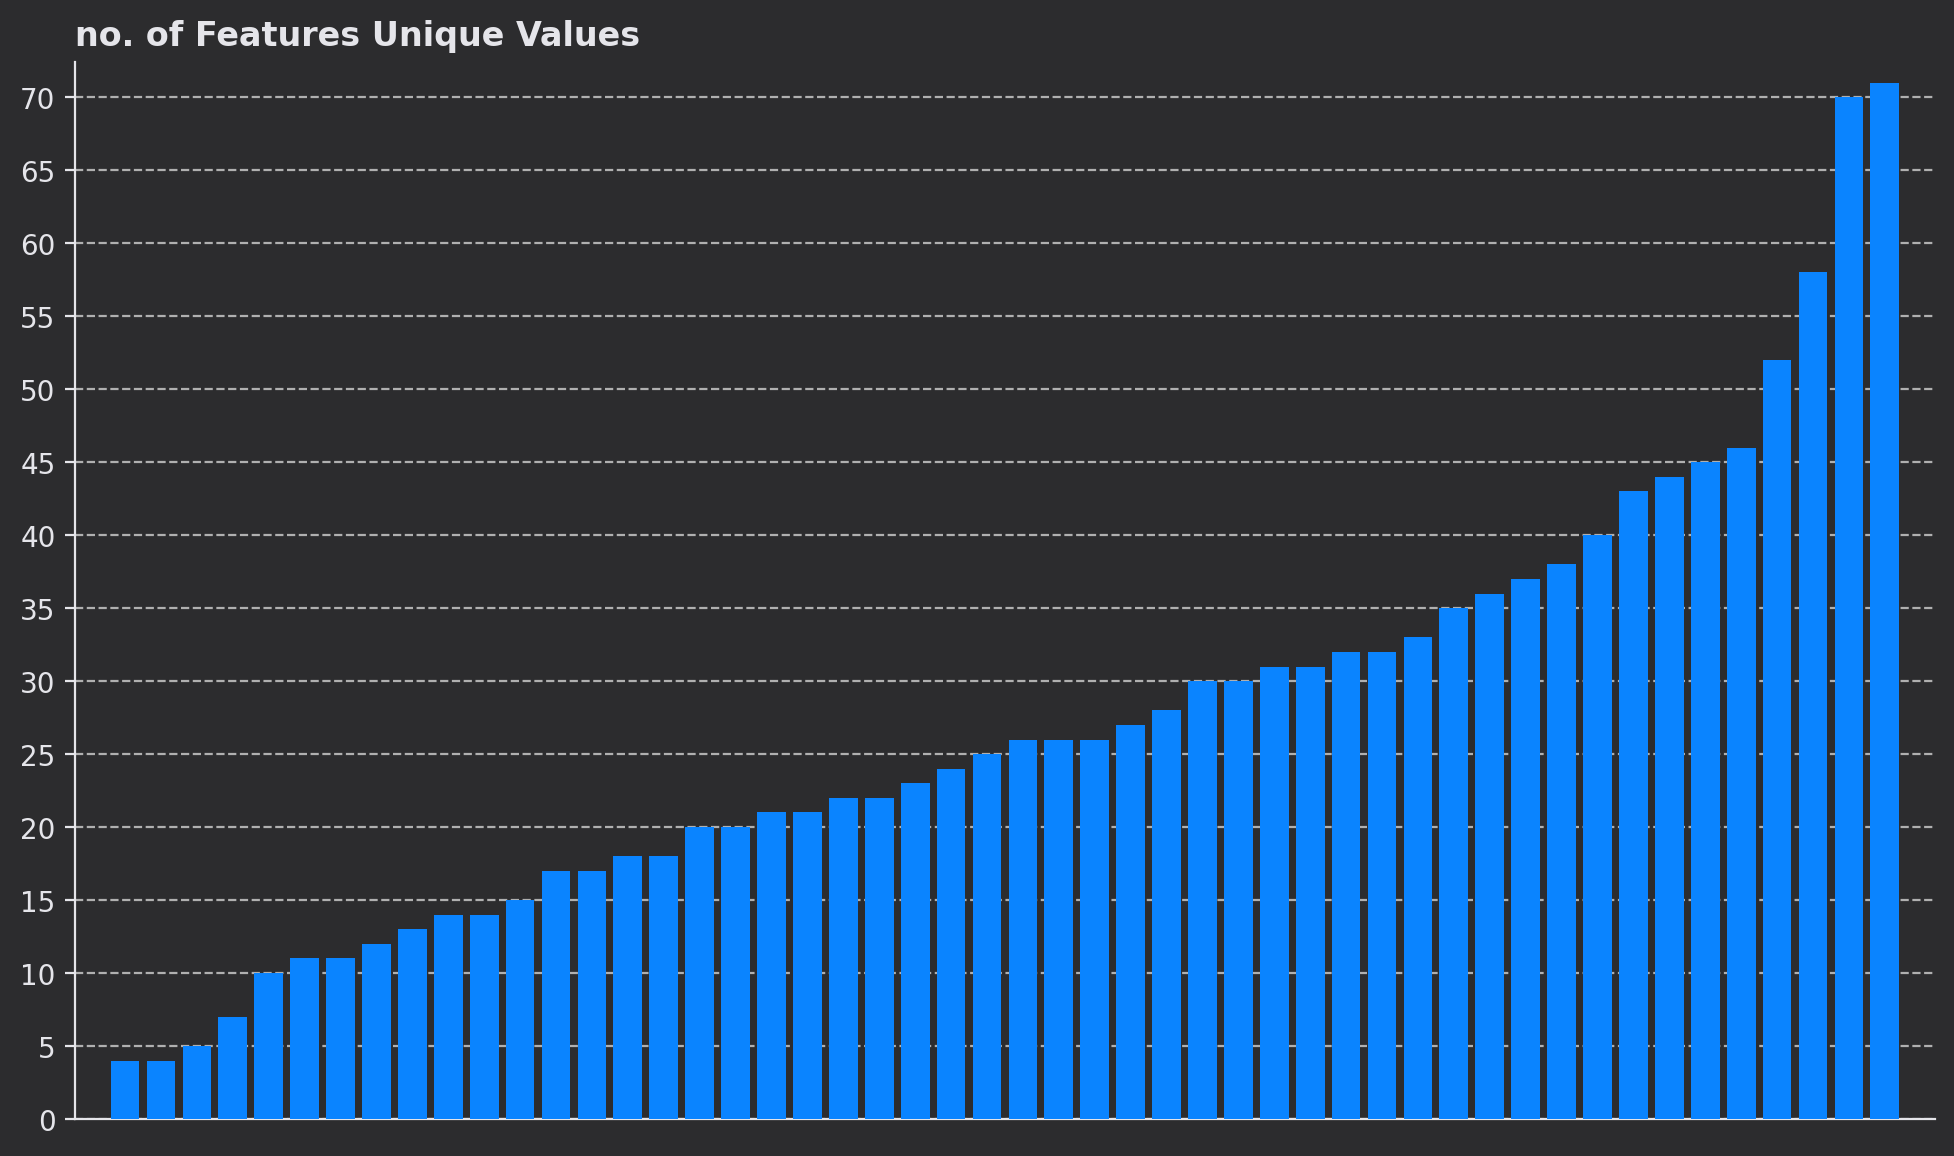

In [7]:
plt.figure(figsize=(12,7))

# x = [f'feature_{i}' for i in range(50)]
y = sorted([len(train[f'feature_{i}'].unique()) for i in range(50)])

plt.bar(range(50), y, zorder=10)
plt.xticks([])
plt.yticks(range(0, 80, 5))
plt.margins(0.02)

plt.title('no. of Features Unique Values', loc='left', fontweight='bold')
plt.grid(axis='y', linestyle='--', zorder=5)
plt.show()

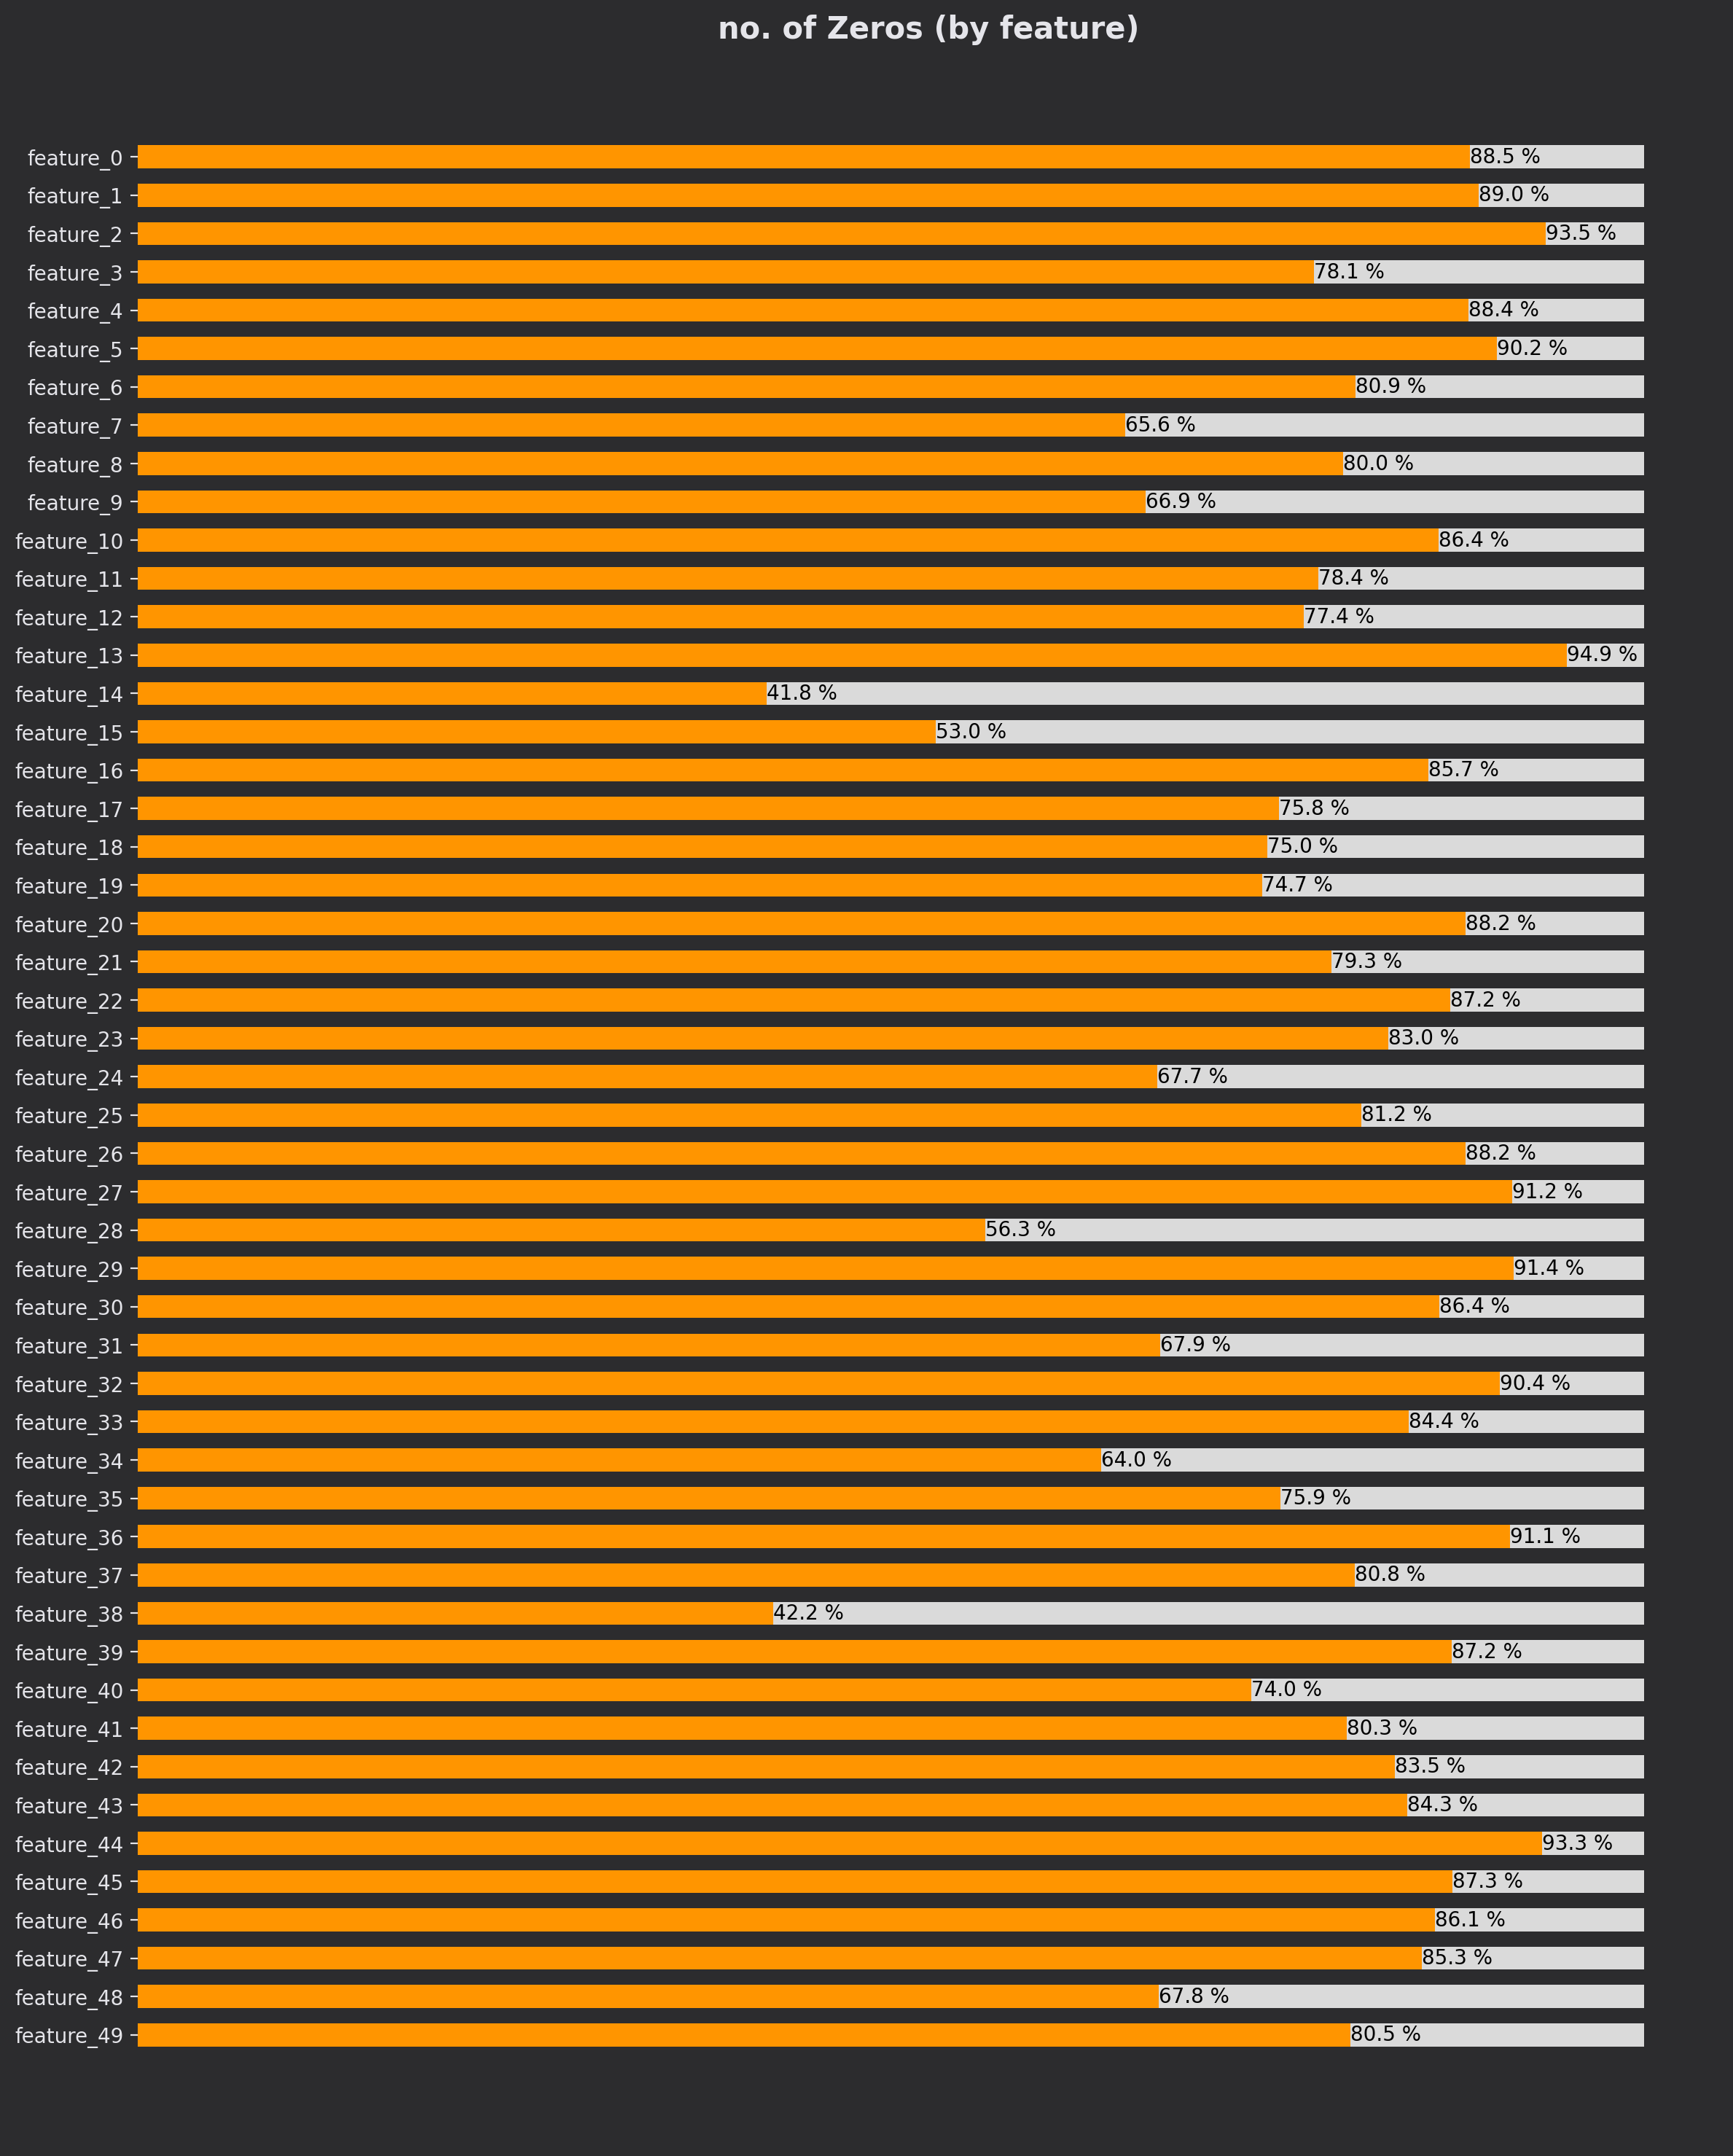

In [8]:
zero_data = ((train.iloc[:,:50]==0).sum() / len(train) * 100)[::-1]
fig, ax = plt.subplots(1,1,figsize=(14, 19))

ax.barh(zero_data.index, 100, color='#dadada', height=0.6)
barh = ax.barh(zero_data.index, zero_data, color=light_palette[1], height=0.6)
ax.bar_label(barh, fmt='%.01f %%', color='black')
ax.spines[['left', 'bottom']].set_visible(False)

ax.set_xticks([])

ax.set_title('no. of Zeros (by feature)', loc='center', fontweight='bold', fontsize=15)    
plt.show()

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['target'] = le.fit_transform(train['target'])

### Model Building

In [10]:
X = train.drop('target',axis=1)
y = train['target']

In [11]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss

def cross_val(X, y, model, params, folds=10):

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=21)
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        alg = model(**params)
        alg.fit(x_train, y_train,
                eval_set=[(x_test, y_test)],
                early_stopping_rounds=100,
                verbose=400)

        pred = alg.predict_proba(x_test)
        loss = log_loss(y_test, pred)
        print(f"Log loss: {loss}")
        print("-"*50)
    
    return alg

In [12]:
catboost_params= {'n_estimators': 20000, 
                  'depth': 4, 
                  'learning_rate': 0.023, 
                  'colsample_bylevel': 0.655, 
                  'bagging_temperature': 0.921, 
                  'l2_leaf_reg': 10.133}

In [13]:
from catboost import CatBoostClassifier
cat_model = cross_val(X, y, CatBoostClassifier, catboost_params)

Fold: 0
0:	learn: 1.3727089	test: 1.3727094	best: 1.3727094 (0)	total: 134ms	remaining: 44m 45s
400:	learn: 1.0974038	test: 1.1014284	best: 1.1014284 (400)	total: 31.6s	remaining: 25m 44s
800:	learn: 1.0888260	test: 1.0959766	best: 1.0959757 (799)	total: 1m 4s	remaining: 25m 35s
1200:	learn: 1.0839635	test: 1.0937873	best: 1.0937873 (1200)	total: 1m 35s	remaining: 24m 47s
1600:	learn: 1.0805098	test: 1.0927877	best: 1.0927877 (1600)	total: 2m 6s	remaining: 24m 8s
2000:	learn: 1.0776860	test: 1.0921223	best: 1.0921223 (2000)	total: 2m 35s	remaining: 23m 22s
2400:	learn: 1.0752446	test: 1.0917592	best: 1.0917592 (2400)	total: 3m 5s	remaining: 22m 38s
2800:	learn: 1.0730045	test: 1.0916023	best: 1.0916023 (2800)	total: 3m 35s	remaining: 22m 1s
3200:	learn: 1.0708800	test: 1.0913849	best: 1.0913761 (3178)	total: 4m 5s	remaining: 21m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.091338424
bestIteration = 3284

Shrink model to first 3285 iterations.
Log loss: 1.091

In [14]:
lgb_params= {'learning_rate': 0.045, 
             'n_estimators': 20000, 
             'max_bin': 94,
             'num_leaves': 10, 
             'max_depth': 27, 
             'reg_alpha': 8.457, 
             'reg_lambda': 6.853, 
             'subsample': 0.749}

In [15]:
from lightgbm import LGBMClassifier
lgb_model = cross_val(X, y, LGBMClassifier, lgb_params)

Fold: 0
Training until validation scores don't improve for 100 rounds
[400]	valid_0's multi_logloss: 1.09315
Early stopping, best iteration is:
[466]	valid_0's multi_logloss: 1.09302
Log loss: 1.093020575067995
--------------------------------------------------
Fold: 1
Training until validation scores don't improve for 100 rounds
[400]	valid_0's multi_logloss: 1.08956
Early stopping, best iteration is:
[420]	valid_0's multi_logloss: 1.08951
Log loss: 1.0895120993519067
--------------------------------------------------
Fold: 2
Training until validation scores don't improve for 100 rounds
[400]	valid_0's multi_logloss: 1.09293
Early stopping, best iteration is:
[436]	valid_0's multi_logloss: 1.09281
Log loss: 1.0928121065480865
--------------------------------------------------
Fold: 3
Training until validation scores don't improve for 100 rounds
[400]	valid_0's multi_logloss: 1.09545
Early stopping, best iteration is:
[351]	valid_0's multi_logloss: 1.09536
Log loss: 1.0953582305850098


In [16]:
xgb_params= {'n_estimators': 20000, 
             'max_depth': 6, 
             'learning_rate': 0.0201, 
             'reg_lambda': 29.326, 
             'subsample': 0.818, 
             'colsample_bytree': 0.235, 
             'colsample_bynode': 0.820, 
             'colsample_bylevel': 0.453}

In [17]:
from xgboost import XGBClassifier
xgb_model = cross_val(X, y, XGBClassifier, xgb_params)

Fold: 0
[09:29:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.37825
[400]	validation_0-mlogloss:1.09765
[800]	validation_0-mlogloss:1.09295
[1200]	validation_0-mlogloss:1.09179
[1312]	validation_0-mlogloss:1.09181
Log loss: 1.0917876271679998
--------------------------------------------------
Fold: 1
[09:32:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.37825
[400]	validation_0-mlogloss:1.09481
[800]	validation_0-mlogloss:1.08941
[1200]	validation_0-mlogloss:1.08824
[1491]	validation_0-mlogloss:1.08805
Log loss: 1.0880192619726061
---------

In [18]:
pred1 = cat_model.predict_proba(test)
pred2 = lgb_model.predict_proba(test)
pred3 = xgb_model.predict_proba(test)
pred = (pred1+pred2+pred3)/3

In [19]:
sample_submission[['Class_1','Class_2', 'Class_3', 'Class_4']] = pred
sample_submission.to_csv(f'submission.csv',index=False)

#### if you like this notebook plz upvote it.
#### Thank you!